# Customers Segmentation for a Credit Card Company

1. [Introduction](#intro)
2. [Data Exploration](#explore)  
    2.1 [Numeric Features](#numeric-features)

# Introduction<a id='intro'></a>
&emsp;In this scenario guided by Dataquest, I will be using a dataset from a fictitious credit card company to segment customers into particular number of groups using K-Means algorithm for marketing purposes.

In [123]:
# Libraries
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
mpl.style.use('tableau-colorblind10')
%matplotlib inline

# Data Exploration<a id='explore'></a>

In [6]:
# Import dataset
customers = pd.read_csv("https://raw.githubusercontent.com/moscmh/creditcard/main/customer_segmentation.csv")

In [10]:
print(f"Records: {customers.shape[0]}\nFeatures: {customers.shape[1]}")
customers.head(3)

Records: 10127
Features: 14


,customer_id,age,gender,dependent_count,education_level,marital_status,estimated_income,months_on_book,total_relationship_count,months_inactive_12_mon,credit_limit,total_trans_amount,total_trans_count,avg_utilization_ratio
0,768805383,45,M,3,High School,Married,69000,39,5,1,12691.0,1144,42,0.061
1,818770008,49,F,5,Graduate,Single,24000,44,6,1,8256.0,1291,33,0.105
2,713982108,51,M,3,Graduate,Married,93000,36,4,1,3418.0,1887,20,0.000


* The customer_id is irrelevant and will be removed.  
* Note that the total_relationship_count refers to the number of times the customer contacted the company.

In [11]:
# Remove id
customers.drop(columns=['customer_id'], inplace=True)

## Numeric Features<a id='numeric-features'></a>

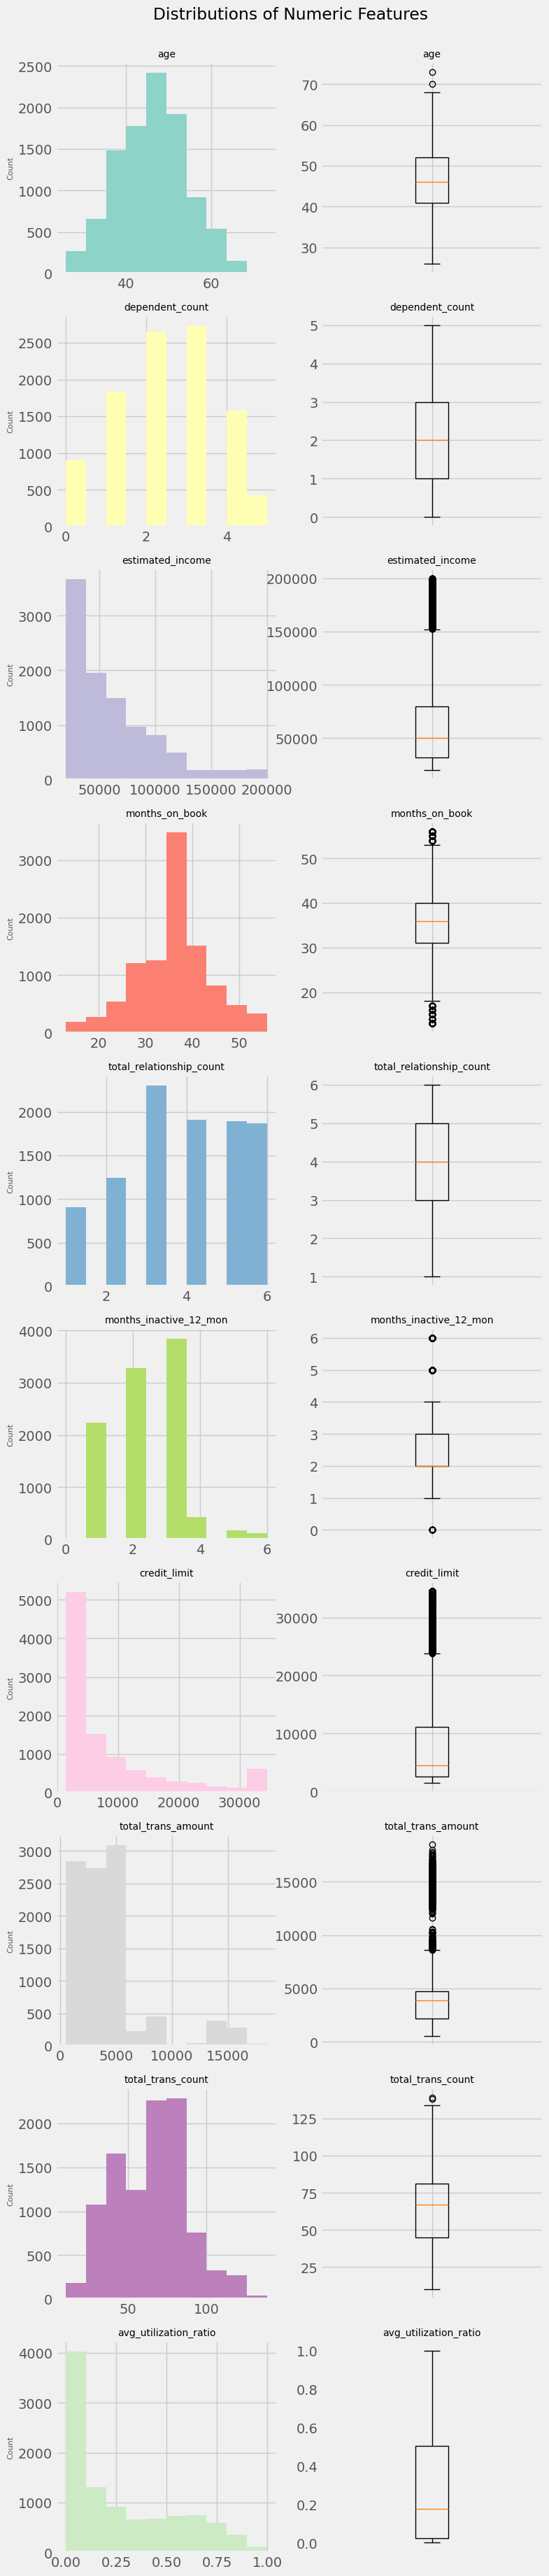

In [158]:
# Numeric features
numeric = list(customers.loc[:,~(customers.dtypes==object)].columns)

cmap = plt.cm.Set3
colors = [cmap(i) for i in np.linspace(0,1,len(numeric)+1)]
fig, axes = plt.subplots(len(numeric),2, figsize=(8,40))
plt.grid(False)
for i, feature in enumerate(numeric):
    axes[i,0].hist(customers[feature], color=colors[i])
    axes[i,0].set_title(feature, fontsize=10)
    axes[i,0].set_ylabel("Count", fontsize=8)
    axes[i,1].boxplot(customers[feature])
    axes[i,1].set_title(feature, fontsize=10)
    axes[i,1].set_xticklabels([])

title = fig.suptitle("Distributions of Numeric Features")
fig.subplots_adjust(top=.96)
# plt.tight_layout()
plt.show()